In [3]:
#basic modules
import numpy as np
import mdtraj as md
from ase import Atoms
import networkx as nx
from tqdm import tqdm
from nglview import show_ase
import matplotlib.pyplot as plt
from typing import Optional, Tuple 
from sklearn.preprocessing import MinMaxScaler
# torch modules
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch import Tensor
from torch.nn import Module
# torch_geometric modules
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
from torch_geometric.nn import BatchNorm,Linear
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.nn import GatedGraphConv
from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

In [4]:

frames=md.load_xtc("./singlesim/it50k/eql2.xtc",top="./singlesim/it50k/conf.gro")
molecule=frames[0]

In [5]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms]
water = Atoms(positions=molecule.xyz[0], numbers=atomic_nums)
show_ase(water)


NGLWidget()

In [6]:
# Relative position of atoms on one molecule
features=[]
for molecule in tqdm(frames):
    # atomic Number
    atomic_nums = np.array(
        [[atom.element.atomic_number for atom in molecule.top.atoms]]).T
    # Vander wall Radii
    vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T
    # Atomic Mass
    mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T
    poitions = molecule.xyz[0]*10 
    # here multiplication by 10 for all of them to be of similar magnitude
    # com = poitions.mean(axis=0)
    node_features = np.concatenate((poitions,vdwr,atomic_nums, mass), axis=1)
    features.append(node_features)
    # relative_pos = poitions-com

    # print("positions:\n", poitions)
    # print("\nVander wall Radii:\n", vdwr)
    # print("\natomic_numbers:\n", atomic_nums)
    # print("\nAtomic Mass:\n", mass)
features=np.array(features)





100%|██████████| 50001/50001 [00:01<00:00, 35213.01it/s]


In [7]:
# node_features = np.concatenate((relative_pos, atomic_nums, vdwr, mass), axis=1)
print("Node Features:\n", features[1])
print("\nNode Features Shape:\n", features[1].shape)

Node Features:
 [[13.4061327  12.54098034 13.48873329  0.152       8.         15.99943   ]
 [12.60031128 13.05296898 13.41979599  0.12        1.          1.007947  ]
 [14.10564613 13.16901016 13.30848122  0.12        1.          1.007947  ]
 [13.39479256 12.66259289 13.46215153  0.          0.          0.        ]]

Node Features Shape:
 (4, 6)


In [8]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list, to_list])


In [9]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [10]:
graphs=[]
for node_features in tqdm(features):
    graph = data.Data(x=torch.from_numpy(node_features),
                  edge_index=torch.from_numpy(edge_list))
    graphs.append(graph)

100%|██████████| 50001/50001 [00:00<00:00, 51465.54it/s]


In [11]:
print(graphs[0])
print(graphs[0].edge_index)

Data(x=[4, 6], edge_index=[2, 4])
tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])


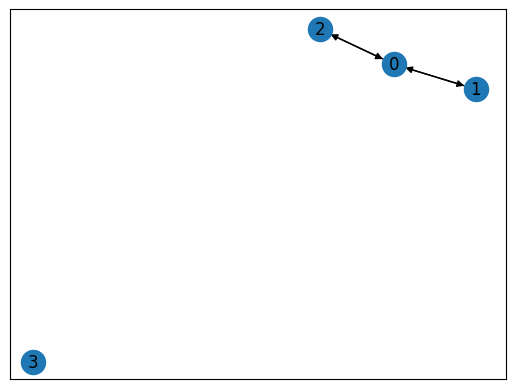

In [12]:
vis = to_networkx(graphs[100])
nx.draw_networkx(vis)

In [13]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index.long()

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [14]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

class VariationalGCNEncoder(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels,batch_size,n_atoms):
        self.embedding_size1=32
        self.embedding_size2=16
        self.linear_size1=32
        self.linear_size2=16
        self.batch_size=batch_size
        self.n_atoms=n_atoms
        self.in_channels=in_channels
        self.out_channels=out_channels

        super().__init__()
        self.conv1 = GATConv(in_channels, self.embedding_size1,heads=3)
        self.head_transform1 = Linear(self.embedding_size1 * 3, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)
        self.conv2=GCNConv(self.embedding_size1, self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)
        # here self.embedding_size2 is the number of features per node
        # and is multiplied by the number of nodes to get the total number of features
        # where number of nodes - n_atoms
        self.linear1=Linear(self.embedding_size2*self.n_atoms,self.linear_size1)
        self.linear2=Linear(self.linear_size1,self.linear_size2)
        # here self.linear_size2 is the number of features per node
        # not multiplied by the number of node

        self.transform=Linear(self.linear_size2,self.out_channels)
        self.mu=Linear(self.out_channels,self.out_channels)
        self.logstd=Linear(self.out_channels,self.out_channels)
    def forward(self, x, edge_index):       
        self.batch_size=x.shape[0]
        x=self.conv1= self.conv1(x, edge_index)
        x=self.head_transform1(x)
        x=self.bn1(x) 
        x=self.conv2(x, edge_index)
        x=self.bn2(x)
        x=self.linear1(x) 
        x=F.leaky_relu(x)
        x=self.linear2(x)
        x=F.leaky_relu(x)
        # using linear_size2 as the number of features per node 
        # instead -1
        x=x.reshape(self.batch_size,self.n_atoms,self.linear_size2)
        # this will reshape the tensor to have the number of nodes as the first dimension
        # and the number of features per node as the second dimension
        # and the number of nodes is n_atoms

        x=x.reshape(self.batch_size,self.n_atoms*self.linear_size2)
        # this will reshape the tensor to have the number of nodes as the first dimension
        # and the number of features per node as the second dimension
        x=self.transform(x)
        x=F.leaky_relu(x)
        x=self.mu(x)
        y=self.logstd(x)
        return x,y,edge_index


In [15]:

class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels,batch_size,n_atoms):
        self.embedding_size1=32
        self.embedding_size2=16
        self.embedding_size3=8
        self.linear_size1=32
        self.linear_size2=16
        self.batch_size=batch_size
        self.n_atoms=n_atoms
        self.in_channels=in_channels
        self.out_channels=out_channels

        super().__init__()
        # different from that one used out_channels instead of in_channels
        # and linear_size2 instead of n_atoms
        self.inv_transform=Linear(self.out_channels,self.linear_size2)       
        # this will reshape the tensor to have the number of nodes as the first dimension
        # and the number of features per node as the second dimension
        # this will be used to convert input to the requires shape
        # shape is batch_size*n_atoms*linear_size2
        self.conv1=GCNConv(self.linear_size2,self.embedding_size2)
        self.bn1 = BatchNorm(self.embedding_size2)
        self.conv2=GCNConv(self.embedding_size2,self.embedding_size1)
        self.bn2 = BatchNorm(self.embedding_size1)
        self.conv3=GCNConv(self.embedding_size1,self.embedding_size3)
        self.linear1=Linear(self.embedding_size3*self.n_atoms,self.linear_size1)
        self.linear2=Linear(self.linear_size1,self.linear_size2)
        self.linear3=Linear(self.linear_size2,self.out_channels)

    def forward(self, z, edge_index,sigmoid=True):
        self.batch_size=z.shape[0]//self.n_atoms
        z=self.inv_transform(z)
        z=F.leaky_relu(z)
        z=z.reshape(self.batch_size,self.n_atoms,self.linear_size2)
        z=z.reshape(self.batch_size,self.n_atoms*self.linear_size2)
        z=self.conv1(z, edge_index)
        z=self.conv2(z, edge_index)
        z=self.conv3(z, edge_index)
        z=self.linear1(z)
        z=F.leaky_relu(z)
        z=self.linear2(z)
        z=F.leaky_relu(z)
        # leaky relu will be used instead of relu
        # it will be used to avoid the dying relu problem
        z=self.linear3(z)
        z=F.leaky_relu(z)


        return z, edge_index
        

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50001/50001 [00:00<00:00, 150280.90it/s]


In [18]:
import os
in_channels = graph.num_features
out_channels = 3
n_atoms = 4
lr = 1e-3
n_epochs = 100
batch_size=256
test_train_split = 0.8
model_name = "IntraVGAE.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels,batch_size,n_atoms),
                VariationalGCNDecoder(out_channels, in_channels,batch_size,n_atoms))
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [19]:
split = int(test_train_split * len(graphs_device))
train_loader = DataLoader(graphs_device[:split], batch_size=batch_size,shuffle=True)
test_loader = DataLoader(graphs_device[split:], batch_size=batch_size,shuffle=True)

In [20]:
print("Using:",device )
print("total_graphs:", len(graphs_device))
print("Graphs in a batch:", batch_size)
print("Train Graphs Batches:",len(train_loader),f"(Total graphs: {len(train_loader)*batch_size})")
print("Test Graphs Batches:",len(test_loader),f"(Total graphs: {len(test_loader)*batch_size})")
print("Model Specifics:\n",model)

Using: cpu
total_graphs: 50001
Graphs in a batch: 256
Train Graphs Batches: 157 (Total graphs: 40192)
Test Graphs Batches: 40 (Total graphs: 10240)
Model Specifics:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(6, 32, heads=3)
    (head_transform1): Linear(96, 32, bias=True)
    (bn1): BatchNorm(32)
    (conv2): GCNConv(32, 16)
    (bn2): BatchNorm(16)
    (linear1): Linear(64, 32, bias=True)
    (linear2): Linear(32, 16, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(6, 16, bias=True)
    (conv1): GCNConv(16, 16)
    (bn1): BatchNorm(16)
    (conv2): GCNConv(16, 32)
    (bn2): BatchNorm(32)
    (conv3): GCNConv(32, 8)
    (linear1): Linear(32, 32, bias=True)
    (linear2): Linear(32, 16, bias=True)
    (linear3): Linear(16, 6, bias=True)
  )
)


In [21]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
     
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]


        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)


        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)

#         positionLoss.backward()
        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader) ,position_loss_all / len(train_loader)

In [22]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]
        
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
   
        
        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [23]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        train_total_loss, train_feature_loss, train_edge_loss,train_position_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss,test_position_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if(early_stopper.early_stop(test_total_loss)):
            print("Early Stopping")
            break

        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_position_losses.append(train_position_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_position_losses.append(test_position_loss)
        
        scheduler.step()

    torch.save(model,"./models/"+model_name)

TypeError: cannot assign 'torch.DoubleTensor' as child module 'conv1' (torch.nn.Module or None expected)

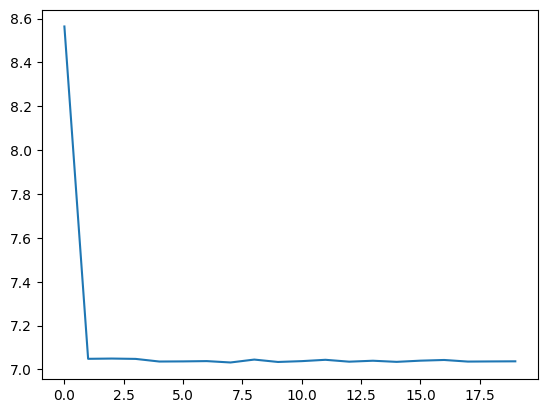

In [ ]:
plt.plot(Losses)


In [ ]:
model.double()
z,encoded_edge_index = model.encode(graph.x, graph.edge_index,batch_size,n_atoms)
r,decoded_edge_index = model.decode(z, encoded_edge_index,batch_size,n_atoms)
decoded_edge_index = graph.edge_index
print("Input Graph features: \n", graph.x)
print("\nInput Edge Index: \n", graph.edge_index)
print("\nEncoded Graph: \n", z)
print("\nDecoded Node features: \n", r)
print("\nDecoded Edge Index: \n", decoded_edge_index)

Input Graph features: 
 tensor([[ 9.7772,  9.0773,  9.8188,  0.1520,  8.0000, 15.9994],
        [10.7062,  8.8494,  9.8558,  0.1200,  1.0000,  1.0079],
        [ 9.3453,  8.2763,  9.5219,  0.1200,  1.0000,  1.0079],
        [ 9.8302,  8.9675,  9.7910,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

Input Edge Index: 
 tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])

Encoded Graph: 
 tensor([[ 1.1416,  0.1774,  1.4214],
        [ 0.7912,  0.6577, -0.2124]], dtype=torch.float64,
       grad_fn=<AddBackward0>)

Decoded Node features: 
 tensor([[9.9131, 8.8796, 9.8316, 0.0000, 4.4899, 8.5040],
        [9.9131, 8.8796, 9.8316, 0.0000, 4.4899, 8.5040],
        [9.7767, 8.4800, 9.6834, 0.0000, 0.4542, 0.9311],
        [9.7767, 8.4800, 9.6834, 0.0000, 0.4542, 0.9311]], dtype=torch.float64,
       grad_fn=<ReluBackward0>)

Decoded Edge Index: 
 tensor([[0, 1, 0, 2],
        [1, 0, 2, 0]])


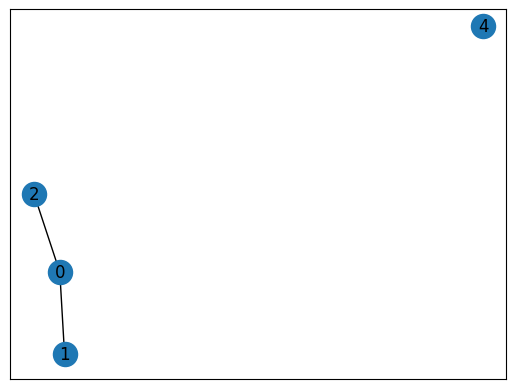

In [ ]:
add_self_loops = False
adj_binary = convert_to_adj(decoded_edge_index, r.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(
        indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw_networkx(G, with_labels=True)
plt.show()
